# Finetune VGG16


With 224x224 melspectrogram images with online data augmentation (Gaussian noise)


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'vgg16_224_augmented'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define a class to add Gaussian noise to the mel spectrogram images for online data augmentation


In [14]:
from data_augmentation.AddGaussianNoise import AddGaussianNoise

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoise(),  # Online noise augmentation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Define test transformations for both validation and test sets
test_transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_8636\1190646824.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.71it/s, Loss=1.9509973526000977, Elapsed=27.0882s, ETA=0.0000s]  


Epoch 1 completed in 111.2077s
Train Loss: 1.492641570940183 - Train Accuracy: 38.48623956943534
Validation Loss: 1.368218002319336 - Validation Accuracy: 45.27226677923174

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.96it/s, Loss=1.7269163131713867, Elapsed=26.7134s, ETA=0.0000s] 


Epoch 2 completed in 105.7627s
Train Loss: 1.4061436470533382 - Train Accuracy: 41.4735080617806
Validation Loss: 1.3549229208628337 - Validation Accuracy: 46.14816378218657

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.8212313652038574, Elapsed=26.7969s, ETA=0.0000s] 


Epoch 3 completed in 105.9416s
Train Loss: 1.4050432140427518 - Train Accuracy: 41.80592930960403
Validation Loss: 1.3196866703033447 - Validation Accuracy: 45.103419164204304

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.95it/s, Loss=1.871155023574829, Elapsed=26.5174s, ETA=0.0000s]  


Epoch 4 completed in 105.0260s
Train Loss: 1.385028692339197 - Train Accuracy: 42.43685126975871
Validation Loss: 1.2804769166310628 - Validation Accuracy: 44.216969185310255

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.72it/s, Loss=1.880867600440979, Elapsed=27.6811s, ETA=0.0000s]   


Epoch 5 completed in 114.2269s
Train Loss: 1.3813334923948166 - Train Accuracy: 42.66072680400715
Validation Loss: 1.2995332129796346 - Validation Accuracy: 45.78936260025327

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.94it/s, Loss=1.8992897272109985, Elapsed=26.7678s, ETA=0.0000s] 


Epoch 6 completed in 105.8265s
Train Loss: 1.3857104034093075 - Train Accuracy: 42.457203591054025
Validation Loss: 1.2990598837534586 - Validation Accuracy: 45.38834951456311

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:14<00:00,  5.04it/s, Loss=1.928353190422058, Elapsed=26.8867s, ETA=0.0000s]  


Epoch 7 completed in 105.1087s
Train Loss: 1.383787151016941 - Train Accuracy: 42.549919721399334
Validation Loss: 1.2746405522028605 - Validation Accuracy: 48.37484170536091

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.974498987197876, Elapsed=26.9040s, ETA=0.0000s]  


Epoch 8 completed in 105.2718s
Train Loss: 1.3789085818163922 - Train Accuracy: 42.75796567241808
Validation Loss: 1.3215506394704184 - Validation Accuracy: 44.25918108906712

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.94it/s, Loss=1.9755524396896362, Elapsed=27.0378s, ETA=0.0000s]  


Epoch 9 completed in 105.6843s
Train Loss: 1.3836174745091123 - Train Accuracy: 42.411976210397775
Validation Loss: 1.260257420539856 - Validation Accuracy: 49.03967918953145

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.91it/s, Loss=1.988631248474121, Elapsed=26.9376s, ETA=0.0000s]   


Epoch 10 completed in 105.6322s
Train Loss: 1.3833780926086998 - Train Accuracy: 42.5612265665634
Validation Loss: 1.2726502323150635 - Validation Accuracy: 49.19797382861967

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:14<00:00,  5.01it/s, Loss=2.2147045135498047, Elapsed=26.7148s, ETA=0.0000s] 


Epoch 11 completed in 105.3519s
Train Loss: 1.3823562478054465 - Train Accuracy: 42.42328305556184
Validation Loss: 1.2685132582982381 - Validation Accuracy: 48.94470240607852

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:14<00:00,  5.01it/s, Loss=1.714855432510376, Elapsed=26.7312s, ETA=0.0000s]  


Epoch 12 completed in 105.1200s
Train Loss: 1.3823097062248715 - Train Accuracy: 42.74892019628683
Validation Loss: 1.2706814002990723 - Validation Accuracy: 46.0953989024905

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:14<00:00,  5.02it/s, Loss=1.57613205909729, Elapsed=26.7548s, ETA=0.0000s]   


Epoch 13 completed in 105.3291s
Train Loss: 1.3787296738238692 - Train Accuracy: 42.88686370728839
Validation Loss: 1.2622804498672486 - Validation Accuracy: 45.12452511608274

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=1.7962912321090698, Elapsed=26.7756s, ETA=0.0000s] 


Epoch 14 completed in 105.6111s
Train Loss: 1.3927465460203976 - Train Accuracy: 42.563487935596214
Validation Loss: 1.27903524239858 - Validation Accuracy: 47.26677923174335

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.96it/s, Loss=1.763534426689148, Elapsed=26.8590s, ETA=0.0000s]  


Epoch 15 completed in 105.4118s
Train Loss: 1.3795843954720248 - Train Accuracy: 43.01123900409308
Validation Loss: 1.2540787998835246 - Validation Accuracy: 45.48332629801604

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:14<00:00,  5.00it/s, Loss=1.8982735872268677, Elapsed=26.8129s, ETA=0.0000s] 


Epoch 16 completed in 105.3111s
Train Loss: 1.3894764684528285 - Train Accuracy: 42.69917007756496
Validation Loss: 1.2617640781402588 - Validation Accuracy: 48.03714647530604

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.94it/s, Loss=1.7585487365722656, Elapsed=26.9823s, ETA=0.0000s]  


Epoch 17 completed in 105.6405s
Train Loss: 1.3784192776404365 - Train Accuracy: 43.10847787250401
Validation Loss: 1.2560251092910766 - Validation Accuracy: 45.09286618826509

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.716375470161438, Elapsed=26.8280s, ETA=0.0000s]  


Epoch 18 completed in 106.1915s
Train Loss: 1.371587936244259 - Train Accuracy: 42.891386445354016
Validation Loss: 1.2600154463450115 - Validation Accuracy: 48.58590122414521

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.8915889263153076, Elapsed=26.9915s, ETA=0.0000s]  


Epoch 19 completed in 106.1111s
Train Loss: 1.3838542772166302 - Train Accuracy: 42.75118156531965
Validation Loss: 1.2639919678370157 - Validation Accuracy: 48.00548754748839

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.5294203758239746, Elapsed=27.1213s, ETA=0.0000s]  


Epoch 20 completed in 106.3690s
Train Loss: 1.3877267327611846 - Train Accuracy: 42.74439745822121
Validation Loss: 1.22502543926239 - Validation Accuracy: 48.11101730688054



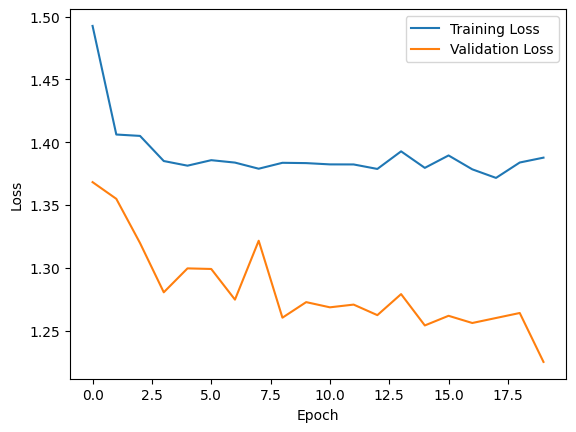

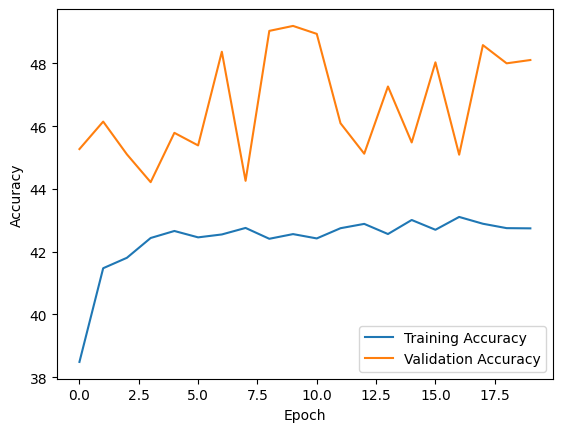

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=train_transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=test_transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [18]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_8636\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]

Test Accuracy: 0.4801
Test Precision: 0.5207
Test Recall: 0.4801
Test F1-score: 0.4683

              precision    recall  f1-score   support

       Anger       0.48      0.49      0.49       916
       Bored       0.59      0.80      0.68      1098
     Disgust       0.25      0.69      0.36       291
        Fear       0.36      0.41      0.38       308
       Happy       0.61      0.22      0.33      1914
     Neutral       0.45      0.49      0.47      2226
    Question       0.70      0.35      0.47      1139
         Sad       0.44      0.59      0.51       857
    Surprise       0.45      0.63      0.52       728

    accuracy                           0.48      9477
   macro avg       0.48      0.52      0.47      9477
weighted avg       0.52      0.48      0.47      9477



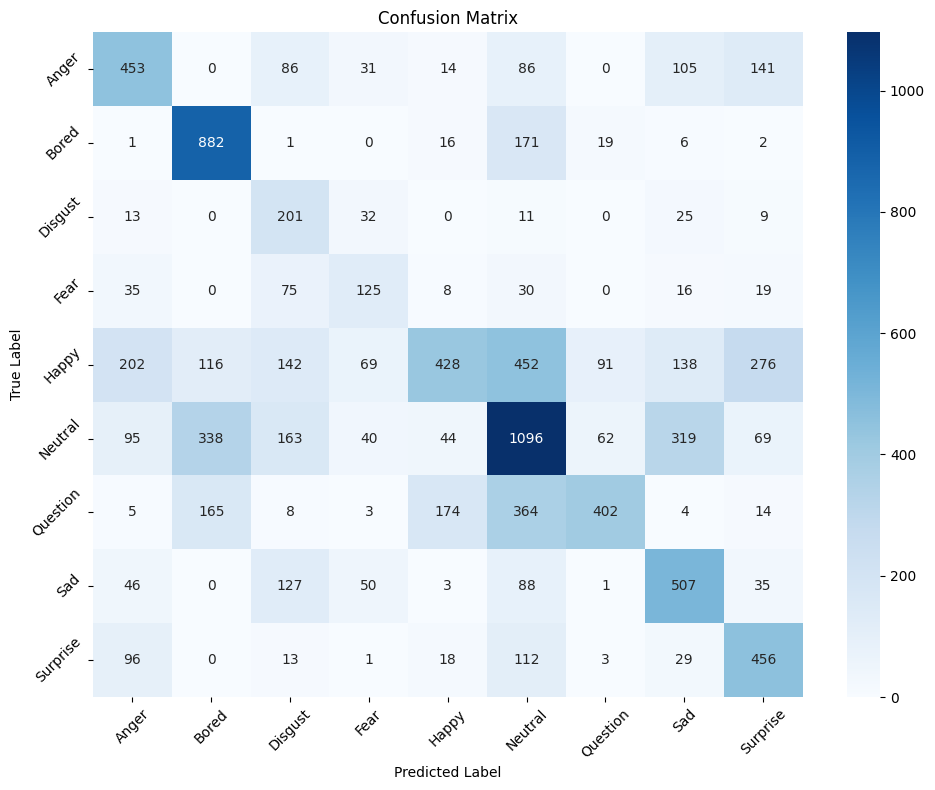

In [20]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)